# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al 2023 preprint) to investigate the effects of transcription factor knockouts (TF KDs)

**Guiding Questions:** What do TF KD effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

# Import statements

In [1]:
# Using psp_env virtual environment
import sys
import os
repo_root = "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/"
if repo_root not in sys.path:
    sys.path.insert(0, "/home/ranwyl/KOLF2.1J_Perturbation_Cell_Atlas/")

import psp
import gc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

# Differential expression analysis - partitioning method

We will carry out differential expression analysis at the gRNA level with PyDESeq2 using a pseudobulk method. The cells for each gRNA are partitioned evenly into pseudoreplicates and compared to an equal number of NTC cells.

## Filter genes

In [2]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [4]:
adata = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [5]:
adata.write("/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_KD_ETest_Gene_Filtered.h5ad")

### Test - DE on gRNA and gene targets

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import gc

def generate_pseudoreplicates_for_DE(adata: ad.AnnData, 
                                     target_value: str, 
                                     ntc_cell_indices: pd.Index, 
                                     rng: np.random.Generator, 
                                     target_column: str = "perturbation", 
                                     min_cells_per_rep: int = 12,
                                     layer: str = "counts"):
    """
    Generate independent pseudoreplicates for a given target (gRNA or gene target) 
    and matched NTC cells. Manually set NTC as reference for DE analysis.
    """
    # Create views for target and NTC cells
    if target_column not in adata.obs:
        print(f"Error: {target_column} not in adata.obs")
        return
    target_mask = adata.obs[target_column] == target_value
    target_view = adata[target_mask]
    ntc_view = adata[ntc_cell_indices]

    # Get data matrices from counts layer
    if layer in adata.layers:
        target_data = target_view.layers[layer]
        ntc_data = ntc_view.layers[layer]
    else:
        target_data = target_view.X
        ntc_data = ntc_view.X        
    
    # Convert to dense if sparse
    if sparse.issparse(target_data):
        target_data = target_data.toarray()
    if sparse.issparse(ntc_data):
        ntc_data = ntc_data.toarray()

    # Calculate number of cells to sample
    n_target_cells = target_data.shape[0]
    n_ntc_cells = ntc_data.shape[0]
    if n_target_cells >= min_cells_per_rep * 2:
        n_reps = min(3, n_target_cells // min_cells_per_rep)
    else: # If too few cells for 2 reps x min_cells_per_rep cells
        n_reps = 2
    target_rep_size = n_target_cells // n_reps
    ntc_rep_size = min(target_rep_size, n_ntc_cells // n_reps)
    if ntc_rep_size < target_rep_size:
        print("Warning: Unmatched number of target and NTC cells")

    # Pre-allocate arrays for results
    target_bulk = np.zeros((n_reps, target_data.shape[1]), dtype=np.int64)
    ntc_bulk = np.zeros((n_reps, ntc_data.shape[1]), dtype=np.int64)

    # Sample cells for all replicates
    target_sample_size = target_rep_size * n_reps
    ntc_sample_size = ntc_rep_size * n_reps
    sampled_target_indices = \
        rng.choice(n_target_cells, target_sample_size, replace=False)
    sampled_ntc_indices = \
        rng.choice(n_ntc_cells, ntc_sample_size, replace=False)
    # Generate replicates using vectorized operations
    for i in range(n_reps):
        # Sample indices
        target_start, target_stop = i*target_rep_size, (i+1)*target_rep_size
        target_rep_indices = sampled_target_indices[target_start:target_stop]
        ntc_start, ntc_stop = i*ntc_rep_size, (i+1)*ntc_rep_size
        ntc_rep_indices = sampled_ntc_indices[ntc_start:ntc_stop]

        # Calculate sums using vectorized operations
        target_bulk[i] = np.sum(target_data[target_rep_indices], axis=0).astype(np.int64)
        ntc_bulk[i] = np.sum(ntc_data[ntc_rep_indices], axis=0).astype(np.int64)  

    # Create sample names
    if "_" in target_value:
        target_value = target_value.replace("_", "-")
    sample_names = [f"{target_value}-rep{i+1}" for i in range(n_reps)]
    control_names = [f"NTC-rep{i+1}" for i in range(n_reps)]
    
    # Combine data
    combined_data = np.vstack([target_bulk, ntc_bulk])
    combined_names = sample_names + control_names
    
    # Create metadata DF
    metadata_df = pd.DataFrame({
        'condition': [target_value] * n_reps + ['NTC'] * n_reps
    }, index=combined_names)
    # Set NTC as reference for DESeq2
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", target_value],
        ordered=True
        )
    
    # Create counts DF
    counts_df = pd.DataFrame(
        combined_data,
        index=combined_names,
        columns=adata.var_names
    )

    return counts_df, metadata_df

def differential_expression(adata: ad.AnnData, 
                    target_column: str = "perturbation", 
                    ntc_cells_delimiter: str = "NTC", 
                    alpha: float = 0.05, n_cpus: int = 20, 
                    min_cells_per_rep: int = 12,
                    layer: str = "counts", random_state: int = 42, 
                    shrink_lfcs: bool = False, debug: bool = False):
    """
    Run differential expression analysis on each perturbation in the dataset.
    """
    # Identify KD and NTC cells
    perturbations = list(adata.obs[target_column].unique())
    perturbations.remove(ntc_cells_delimiter) # Remove NTC group
    if debug == True: # Debug mode: run with 3 perturbations
        print(f"Running in debug mode with 3 perturbations")
        perturbations = perturbations[:3]
    ntc_cell_indices = np.where(adata.obs[target_column] == ntc_cells_delimiter)[0]

    # Create RNG object
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per perturbation
    streams = de_rng.spawn(len(perturbations))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)

    # Warning if given layer not found
    if layer not in adata.layers:
         print(f"Warning: {layer} not in adata.layers, using adata.X instead")

    # Function to run DE analysis on a single perturbation
    quiet = True
    def process_perturbation(target_value: str, rng: np.random.Generator, quiet=quiet):
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            adata, target_value, ntc_cell_indices, rng, 
            target_column=target_column, min_cells_per_rep=min_cells_per_rep,
            layer=layer
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=quiet
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_value.replace('_', '-')
        contrast = ["condition", target_hyphenated, ntc_cells_delimiter]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=quiet)
        stat_res.summary()
        if shrink_lfcs == True:
            # Shrink LFCs for downstream analysis
            stat_res.lfc_shrink(coeff=f"condition_{contrast[1]}_vs_{contrast[2]}", 
                                adapt=False)
        results_df = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res
        gc.collect()

        # Return results with and without LFC shrinkage
        return results_df

    # Run DE analysis on all perturbations in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(perturbations)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_perturbation)(target_value, rng)
            for target_value, rng in zip(perturbations, streams))
    
    results_dict = dict(zip(perturbations, results))
    return results_dict

def build_de_df(results_dict: dict):
    """
    Build DF of all DE results: baseMean, log2FoldChange, lfcSE, 
    stat (LFC divided by LFC SE), pvalue, padj.
    """
    df_list = list()
    for gene_target, df in results_dict.items():
        # Sort genes alphabetically
        df = df.sort_index()
        # Prepend perturbation name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    if len(df_list) > 1:
        # Concatenate all DE result DataFrames (using intersection of genes)
        de_df = pd.concat(df_list, axis=1)
        de_df = de_df.sort_index()
    return de_df

def build_deg_df(de_df: pd.DataFrame, 
                 perturbation: str, 
                 padj_threshold: float = 0.05,
                 lfc_threshold: float = 0):
    """
    Return DE results filtered to only the given perturbation and only
    genes that pass p-adj threshold (alpha) and LFC threshold.
    """
    perturbation_cols = de_df.columns[de_df.columns.str.contains(perturbation)]
    perturbation_df = de_df[perturbation_cols]
    perturbation_deg_df = \
        perturbation_df[
            (perturbation_df[f"{perturbation}_padj"] < padj_threshold) & 
            (abs(perturbation_df[f"{perturbation}_log2FoldChange"]) > lfc_threshold)
            ]
    return perturbation_deg_df


In [3]:
data_path = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Alpha_CPMnorm_Knockdown_Energy_Test_Filtered.h5ad"
adata = psp.utils.read_anndata(data_path)
adata

AnnData object with n_obs × n_vars = 101923 × 20043
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [4]:
# 30 KDs with highest number of DEGs, from updated pipeline example notebook
top_30_kds_by_n_degs = \
    {'MYADM', 'DBR1', 'POU5F1', 'PTPN1', 'POU5F1B', 'JOSD1', 'ST13', 'HRC', 'TOMM40', 'KAT2A', 
     'PHF20', 'PSMD8', 'NAE1', 'POU3F2', 'HCCS', 'DDX6', 'SMARCC1', 'DNMT1', 'TMX2', 'SMARCE1', 
     'TADA2B', 'VHL', 'TAF4', 'EMSY', 'ZNF521', 'RBM14', 'NANOG', 'IDI1', 'RNF7', 'ZNF396'}

# KDs to test
test_kds = top_30_kds_by_n_degs & set(adata.obs.gene_target.unique().tolist())
print(f"{len(test_kds)} KDs to test: {', '.join(test_kds)}")

# gRNA to test
gRNA_to_test = adata[adata.obs.gene_target.isin(test_kds)].obs.gRNA.unique().tolist()
print(f"{len(gRNA_to_test)} gRNA to test")

8 KDs to test: POU5F1, DNMT1, POU5F1B, PHF20, POU3F2, ZNF396, ZNF521, NANOG
14 gRNA to test


Apply stricter gene filter

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
import seaborn as sns
import scanpy as sc

def filter_low_expressed_genes(adata, percent_threshold=0, min_n_cells=0, silent=False):
    """
    Filter out bottom percentile of genes with lowest expression (counts) 
    and genes expressed in fewer than min_n_cells cells.
    Do not filter out genes that are gene_targets in adata.
    """
    n_genes_before = adata.shape[1]

    # Filter genes expressed in fewer than min_n_cells cells
    if silent == False:
        print(f"Removing non-TF genes expressed in <{min_n_cells} cells")
    # Create data matrix
    if silent == False:
        print("Copying data")
    data_matrix = adata.layers["counts"] if "counts" in adata.layers else adata.X
    data_matrix = data_matrix.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate number of cells expressing each gene
    gene_detected_counts = (data_matrix > 0).sum(axis=0)
    # Set cell number threshold and filter genes
    genes_pass_cell_thr = gene_detected_counts >= min_n_cells
    genes_to_keep = genes_pass_cell_thr | tf_mask
    adata = adata[:, genes_to_keep]
    print(f"Removed {n_genes_before - adata.n_vars} "
        f"non-TF genes expressed in <{min_n_cells} cells")
    n_genes_after_cell_filt = adata.n_vars
    del data_matrix

    # Filter bottom percentile of genes by expression (counts)
    if silent == False:
        print(f"\nRemoving bottom {percent_threshold}% of genes by expression (CPM)")
    if silent == False:
        print("Copying data")
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    if silent == False:
        print("Copying normalized data")
    data_matrix = adata_norm.X.copy()
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        if silent == False:
            print("Converting data from sparse to dense")
        data_matrix = data_matrix.toarray()
    if silent == False:
        print("Filtering genes")
    # Create mask for TFs
    tf_mask = adata.var_names.isin(adata.obs.gene_target.unique().tolist())
    # Calculate mean expression of each gene
    mean_expr_per_gene = data_matrix.mean(axis=0)
    # Set percent threshold and filter genes
    threshold = np.percentile(mean_expr_per_gene, percent_threshold)
    genes_pass_pct_thr = mean_expr_per_gene > threshold
    genes_to_keep = genes_pass_pct_thr | tf_mask
    adata = adata[:,genes_to_keep]
    print(f"Removed {n_genes_after_cell_filt - adata.n_vars} non-TF genes "
            f"with lowest {percent_threshold}% expression (CPM)")
    print(f"\nRemoved: {n_genes_before - adata.shape[1]} genes total")
    print(f"Remaining: {adata.n_vars} genes")
    del data_matrix
    del adata_norm
    gc.collect()
    return adata.copy()

In [6]:
adata = filter_low_expressed_genes(adata, min_n_cells=100, percent_threshold=20)

Removing non-TF genes expressed in <100 cells
Copying data
Converting data from sparse to dense
Filtering genes
Removed 188 non-TF genes expressed in <100 cells

Removing bottom 20% of genes by expression (CPM)
Copying data
normalizing counts per cell
    finished (0:00:00)
Copying normalized data
Converting data from sparse to dense
Filtering genes
Removed 3740 non-TF genes with lowest 20% expression (CPM)

Removed: 3928 genes total
Remaining: 16115 genes


In [7]:
adata

AnnData object with n_obs × n_vars = 101923 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

Test

In [8]:
test_adata = adata[(adata.obs.perturbed == "False") |
                   (adata.obs.gene_target.isin(test_kds))].copy()
test_adata

AnnData object with n_obs × n_vars = 14437 × 16115
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'perturbation', 'gene_target_ensembl_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'perturbation_edist', 'perturbation_pvalue', 'perturbation_significant'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'etest_results', 'etest_results_params'
    layers: 'counts'

In [9]:
test_adata.obs.perturbed.value_counts()

perturbed
False    13674
True       763
Name: count, dtype: int64

In [ ]:
print(f"test_adata gene targets: {', '.join(test_adata.obs.gene_target.unique().tolist())}")

test_adata gene targets: NTC, PHF20, DNMT1, POU5F1, NANOG, ZNF396, POU5F1B, POU3F2, ZNF521


In [12]:
test_de_results12 = differential_expression(test_adata, min_cells_per_rep=12)

Running DE analysis:   0%|          | 0/14 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()


In [13]:
test_de_results15 = differential_expression(test_adata, min_cells_per_rep=15)

Running DE analysis:   0%|          | 0/14 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

In [14]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results = psp.de.differential_expression(test_adata_pipeline, plot_degs=False)

Processing perturbations:   0%|          | 0/14 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-10-24 15:13:14 - INFO - Completed differential expression analysis in 135.26 seconds


In [15]:
def build_DE_test_results_df(tf_de_results: dict, pipeline_de_results: dict, 
                             adata: ad.AnnData, tf_min_cells_per_rep: int,
                             pipeline_sample_fraction: float=0.7, 
                             alpha: float=0.05, target_column: str = "gRNA"):
    
    target_list = sorted(list(tf_de_results.keys()))
    n_cells_list = [adata[adata.obs[target_column] == target].shape[0] for target in target_list]
    tf_reps_cells_list, tf_n_degs_list = list(), list()
    pipeline_reps_cells_list, pipeline_n_degs_list = list(), list()

    for i in range(len(target_list)):
        target = target_list[i]
        # TF project n_reps x n_cells
        n_cells = n_cells_list[i]
        if n_cells < 2 * tf_min_cells_per_rep:
            res = f"2 x {n_cells // 2} cells"
        else:
            n_reps = min(3, n_cells // tf_min_cells_per_rep)
            n_cells_per_rep = n_cells // n_reps
            res = f"{n_reps} x {n_cells_per_rep} cells"
        tf_reps_cells_list.append(res)
        # Pipeline n_reps x n_cells
        res = f"3 x {int(n_cells * pipeline_sample_fraction)} cells"
        pipeline_reps_cells_list.append(res)
        # TF project number of DEGs
        de_df = tf_de_results[target]
        degs = set(de_df[de_df["padj"] < alpha].index.tolist())
        tf_n_degs_list.append(len(degs))
        # Pipeline number of DEGs
        de_df = pipeline_de_results[target]
        degs = set(de_df[de_df["padj"] < alpha].index.tolist())
        pipeline_n_degs_list.append(len(degs))
    
    results_dict = {target_column: target_list, 
                    "# cells": n_cells_list, 
                    "TF # DEGs": tf_n_degs_list,
                    "Pipeline # DEGs": pipeline_n_degs_list,
                    "TF reps x cells": tf_reps_cells_list,
                    "Pipeline reps x cells": pipeline_reps_cells_list}         
    results_df = pd.DataFrame.from_dict(results_dict)
    return results_df

In [16]:
de_test_results_df12 = \
    build_DE_test_results_df(test_de_results12, pipeline_de_results, test_adata, 
                             tf_min_cells_per_rep=12,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05)

In [17]:
display(de_test_results_df12.sort_values(by="# cells"))

,gRNA,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
8,POU5F1_1,27,40,489,2 x 13 cells,3 x 18 cells
9,POU5F1_2,29,33,533,2 x 14 cells,3 x 20 cells
3,NANOG_1,38,3,60,3 x 12 cells,3 x 26 cells
7,POU5F1B_1,44,100,656,3 x 14 cells,3 x 30 cells
1,DNMT1_2,45,14,80,3 x 15 cells,3 x 31 cells
5,PHF20_1,46,95,412,3 x 15 cells,3 x 32 cells
6,POU3F2_2,50,62,403,3 x 16 cells,3 x 35 cells
0,DNMT1_1,50,5,71,3 x 16 cells,3 x 35 cells
10,POU5F1_3,50,94,550,3 x 16 cells,3 x 35 cells
12,ZNF396_2,51,38,188,3 x 17 cells,3 x 35 cells


In [18]:
de_test_results_df15 = \
    build_DE_test_results_df(test_de_results15, pipeline_de_results, test_adata, 
                             tf_min_cells_per_rep=15,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05)

In [19]:
display(de_test_results_df15.sort_values(by="# cells"))

,gRNA,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
8,POU5F1_1,27,40,489,2 x 13 cells,3 x 18 cells
9,POU5F1_2,29,33,533,2 x 14 cells,3 x 20 cells
3,NANOG_1,38,1,60,2 x 19 cells,3 x 26 cells
7,POU5F1B_1,44,58,656,2 x 22 cells,3 x 30 cells
1,DNMT1_2,45,14,80,3 x 15 cells,3 x 31 cells
5,PHF20_1,46,95,412,3 x 15 cells,3 x 32 cells
6,POU3F2_2,50,62,403,3 x 16 cells,3 x 35 cells
0,DNMT1_1,50,5,71,3 x 16 cells,3 x 35 cells
10,POU5F1_3,50,94,550,3 x 16 cells,3 x 35 cells
12,ZNF396_2,51,38,188,3 x 17 cells,3 x 35 cells


In [20]:
test_de_results_gene_target = differential_expression(test_adata, 
                                                      target_column="gene_target",
                                                      min_cells_per_rep=12)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
test_adata_pipeline = test_adata.copy()
pipeline_de_results_gene_target = \
    psp.de.differential_expression(test_adata_pipeline, 
                                   adata_deg_test_column="gene_target",
                                   plot_degs=False)

Processing perturbations:   0%|          | 0/8 [00:00<?, ?it/s]


Updating adata object with DEG counts
2025-10-24 15:23:00 - INFO - Completed differential expression analysis in 80.11 seconds


In [22]:
de_test_results_gene_target_df = \
    build_DE_test_results_df(test_de_results_gene_target, 
                             pipeline_de_results_gene_target, 
                             test_adata, 
                             tf_min_cells_per_rep=12,
                             pipeline_sample_fraction=0.7,
                             alpha=0.05,
                             target_column="gene_target")

In [23]:
display(de_test_results_gene_target_df.sort_values(by="# cells"))

,gene_target,# cells,TF # DEGs,Pipeline # DEGs,TF reps x cells,Pipeline reps x cells
5,POU5F1B,44,122,585,3 x 14 cells,3 x 30 cells
2,PHF20,46,95,544,3 x 15 cells,3 x 32 cells
3,POU3F2,50,57,443,3 x 16 cells,3 x 35 cells
7,ZNF521,83,62,317,3 x 27 cells,3 x 58 cells
4,POU5F1,106,436,1565,3 x 35 cells,3 x 74 cells
1,NANOG,119,61,265,3 x 39 cells,3 x 83 cells
0,DNMT1,147,70,338,3 x 49 cells,3 x 102 cells
6,ZNF396,168,11,132,3 x 56 cells,3 x 117 cells


### Test - NTC benchmarking

In [27]:
def benchmark_NTC_FDR(
    adata: ad.AnnData,
    gRNA_column: str = "gRNA",
    ntc_cells_delimiter: str = "Non-Targeting",
    layer: str = "counts",
    min_cells_per_rep: int = 12,
    alpha: float = 0.05,
    n_cpus: int = 16,
    random_state: int = 42,
    debug: bool = False
):
    """
    Benchmark FDR control by comparing NTC sgRNAs against each other.
    For each NTC sgRNA, run DE analysis against all other NTC sgRNAs.
    Calculate distribution of DEGs (FDR < 0.05) per NTC sgRNA. 
    Determine threshold at which 95% of NTC sgRNAs have fewer DEGs.
    Add a column to adata.obs indicating if each perturbation exceeds
    the NTC FDR threshold. Not batch-aware. No results stored in adata.

    gRNA_column: adata.obs column with identifier for each sgRNA, default "gRNA"
    ntc_cells_delimiter: prefix of NTC sgRNA in gRNA column, default "Non-Targeting"
    layer: AnnData object layer to use for DE analysis, default "counts"
    alpha: significance threshold for DESeq2, default 0.05
    """
    # Get AnnData with only NTC cells based on gRNA_column and delimiter
    ntc_mask = adata.obs[gRNA_column].astype(str).str.contains(ntc_cells_delimiter)
    if not ntc_mask.any():
        raise ValueError(f"No NTC cells found in {gRNA_column} containing "
                         f"'{ntc_cells_delimiter}'")
    ntc_adata = adata[ntc_mask].copy()

    # Get unique NTC sgRNAs
    if gRNA_column not in ntc_adata.obs.columns:
        raise ValueError(f"Column '{gRNA_column}' not found in adata.obs")
    ntc_sgRNAs = list(ntc_adata.obs[gRNA_column].unique())
    if len(ntc_sgRNAs) < 3:
        print(f"Not enough unique NTC sgRNAs for benchmarking (need at least 3, found {len(ntc_sgRNAs)})")
        return
    if debug == True:
        print("Running in debug mode with 5 NTC sgRNA")
        ntc_sgRNAs = ntc_sgRNAs[:5]

    # Create RNG object to handle case where one is not provided
    de_rng = np.random.default_rng(random_state)
    # Create one child RNG object per NTC sgRNA
    streams = de_rng.spawn(len(ntc_sgRNAs))

    # Determine how many CPUs to use per joblib Parallel job
    #   and per DE analysis run
    if n_cpus < 3:
        n_cpus_for_DE = n_cpus
    elif n_cpus <= 10:
        n_cpus_for_DE = 3
    elif 20 <= n_cpus < 30:
        n_cpus_for_DE = 4
    elif 30 <= n_cpus < 50:
        n_cpus_for_DE = 5
    else:
        n_cpus_for_DE = 6
    n_jobs = max(1, n_cpus // n_cpus_for_DE)
    
    # Warning if given layer not found
    if layer not in adata.layers:
        print(f"Warning: {layer} not found in adata.layers, using adata.X instead")

    # Helper function
    def process_ntc_gRNA(target_ntc_gRNA: str,
                         rng: np.random.Generator):
        # Check if there are enough target cells
        target_cells = ntc_adata[ntc_adata.obs[gRNA_column] == target_ntc_gRNA].obs.index
        if len(target_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few cells ({len(target_cells)})")
            return
        
        # Get other NTC cells (excluding the target gRNA)
        other_ntc_cells = ntc_adata[ntc_adata.obs[gRNA_column] != target_ntc_gRNA].obs.index
        if len(other_ntc_cells) < 10:
            print(f"Skipping {target_ntc_gRNA}: too few other NTC cells ({len(other_ntc_cells)})")
            return
        
        # Temporarily create "perturbation" column to use with generate_pseudoreplicates_for_DE
        # This labels target gRNA cells as the "perturbation" and other NTC cells as "NTC"
        ntc_adata_temp = ntc_adata.copy()
        ntc_adata_temp.obs["temp_pert"] = "NTC"
        ntc_adata_temp.obs.loc[ntc_adata_temp.obs[gRNA_column] == target_ntc_gRNA, 'temp_pert'] = target_ntc_gRNA
        
        # Generate pseudoreplicates
        pseudo_bulk_df, metadata_df = generate_pseudoreplicates_for_DE(
            ntc_adata_temp, target_ntc_gRNA, other_ntc_cells, rng, 
            target_column="temp_pert", layer=layer, 
            min_cells_per_rep=min_cells_per_rep
        )

        # Set number of CPUs to use for each DE run
        inference = DefaultInference(n_cpus=n_cpus_for_DE) 

        # Read counts modeling and fitting dispersions
        dds = DeseqDataSet(
            counts = pseudo_bulk_df, 
            metadata = metadata_df,
            refit_cooks=True,
            inference=inference,
            quiet=True
            )
        dds.deseq2()
        
        # Statistical testing
        target_hyphenated = target_ntc_gRNA.replace('_', '-')
        contrast = ["condition", target_hyphenated, "NTC"]
        stat_res = DeseqStats(
            dds, 
            contrast=contrast, 
            alpha=alpha,
            inference=inference,
            quiet=True)
        stat_res.summary()
        de_results = stat_res.results_df

        # Clean up memory
        del pseudo_bulk_df, metadata_df, dds, stat_res, ntc_adata_temp
        gc.collect()

        return de_results

    # Run DE analysis on all NTC sgRNA in parallel
    with tqdm_joblib(desc="Running DE analysis", total=len(ntc_sgRNAs)):
        de_results = Parallel(n_jobs=n_jobs)(
            delayed(process_ntc_gRNA)(target_value, rng) 
            for target_value, rng in zip(ntc_sgRNAs, streams))
    results_dict = dict(zip(ntc_sgRNAs, de_results))

    # Check for successful comparisons
    if not results_dict:
        print("No successful comparisons. Check if the data layer contains integer counts.")
        return
    
    # Calculate DEGs per sgRNA-batch (handles sgRNA names with underscores)
    deg_counts = {}
    for key, result_df in results_dict.items():
        if result_df is None:
            continue
        count_key = key
        # Count DEGs for this comparison
        deg_count = sum((result_df['padj'] < alpha) & pd.notna(result_df['padj']))
        deg_counts[count_key] = deg_count

    # Check if we have any DEG counts
    if not deg_counts:
        print("No DEGs found in any comparison.")
        return

    # Create results DataFrame
    benchmark_results = pd.DataFrame.from_dict(deg_counts, orient='index', columns=['n_DEGs'])
    benchmark_results['sgRNA'] = benchmark_results.index

    benchmark_results.index.name = 'key'
    benchmark_results = benchmark_results.sort_values('n_DEGs', ascending=False)
    
    # Calculate 95th percentile threshold (FDR 0.05)
    if len(benchmark_results) > 0:
        deg_threshold = np.percentile(benchmark_results['n_DEGs'].values, 95)
    else:
        print("No results to calculate percentile.")
        return
    
    # Print statistics
    print(f"NTC Benchmark Statistics:")
    print(f"  • FDR 0.05 threshold: {int(deg_threshold)} DEGs")
    print(f"  • NTC comparisons analyzed: {len(benchmark_results)}")
    print(f"  • Mean DEGs per comparison: {benchmark_results['n_DEGs'].mean():.1f}")
    print(f"  • Median DEGs per comparison: {benchmark_results['n_DEGs'].median():.1f}")
    print(f"  • 95% of comparisons have < {int(deg_threshold)} DEGs")

    return int(deg_threshold), benchmark_results

In [40]:
test_deg_threshold, test_benchmark_results = \
    benchmark_NTC_FDR(test_adata, debug=True)

Running in debug mode with 5 NTC sgRNA


Running DE analysis:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 5
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [25]:
deg_threshold, benchmark_results = \
    benchmark_NTC_FDR(adata)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/psp_env/lib64/python3.11/site

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


In [28]:
deg_threshold, benchmark_results = \
    benchmark_NTC_FDR(adata, min_cells_per_rep=20)

Running DE analysis:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is es

NTC Benchmark Statistics:
  • FDR 0.05 threshold: 0 DEGs
  • NTC comparisons analyzed: 234
  • Mean DEGs per comparison: 0.0
  • Median DEGs per comparison: 0.0
  • 95% of comparisons have < 0 DEGs


2025-10-30 14:00:30 - INFO - Using 13674 non-targeting control cells for benchmarking
2025-10-30 14:00:30 - INFO - Found 234 unique NTC sgRNAs
2025-10-30 14:00:30 - WARNING - Running in DEBUG mode with only 3 NTC sgRNAs


Benchmarking NTC sgRNAs:   0%|          | 0/3 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


2025-10-30 14:00:58 - INFO - Stored NTC FDR threshold (0) in adata.uns['ntc_fdr_threshold']
2025-10-30 14:00:58 - INFO - NTC Benchmark Statistics:
2025-10-30 14:00:58 - INFO -   • FDR 0.05 threshold: 0 DEGs
2025-10-30 14:00:58 - INFO -   • NTC comparisons analyzed: 3
2025-10-30 14:00:58 - INFO -   • Mean DEGs per comparison: 0.0
2025-10-30 14:00:58 - INFO -   • Median DEGs per comparison: 0.0
2025-10-30 14:00:58 - INFO -   • 95% of comparisons have < 0 DEGs


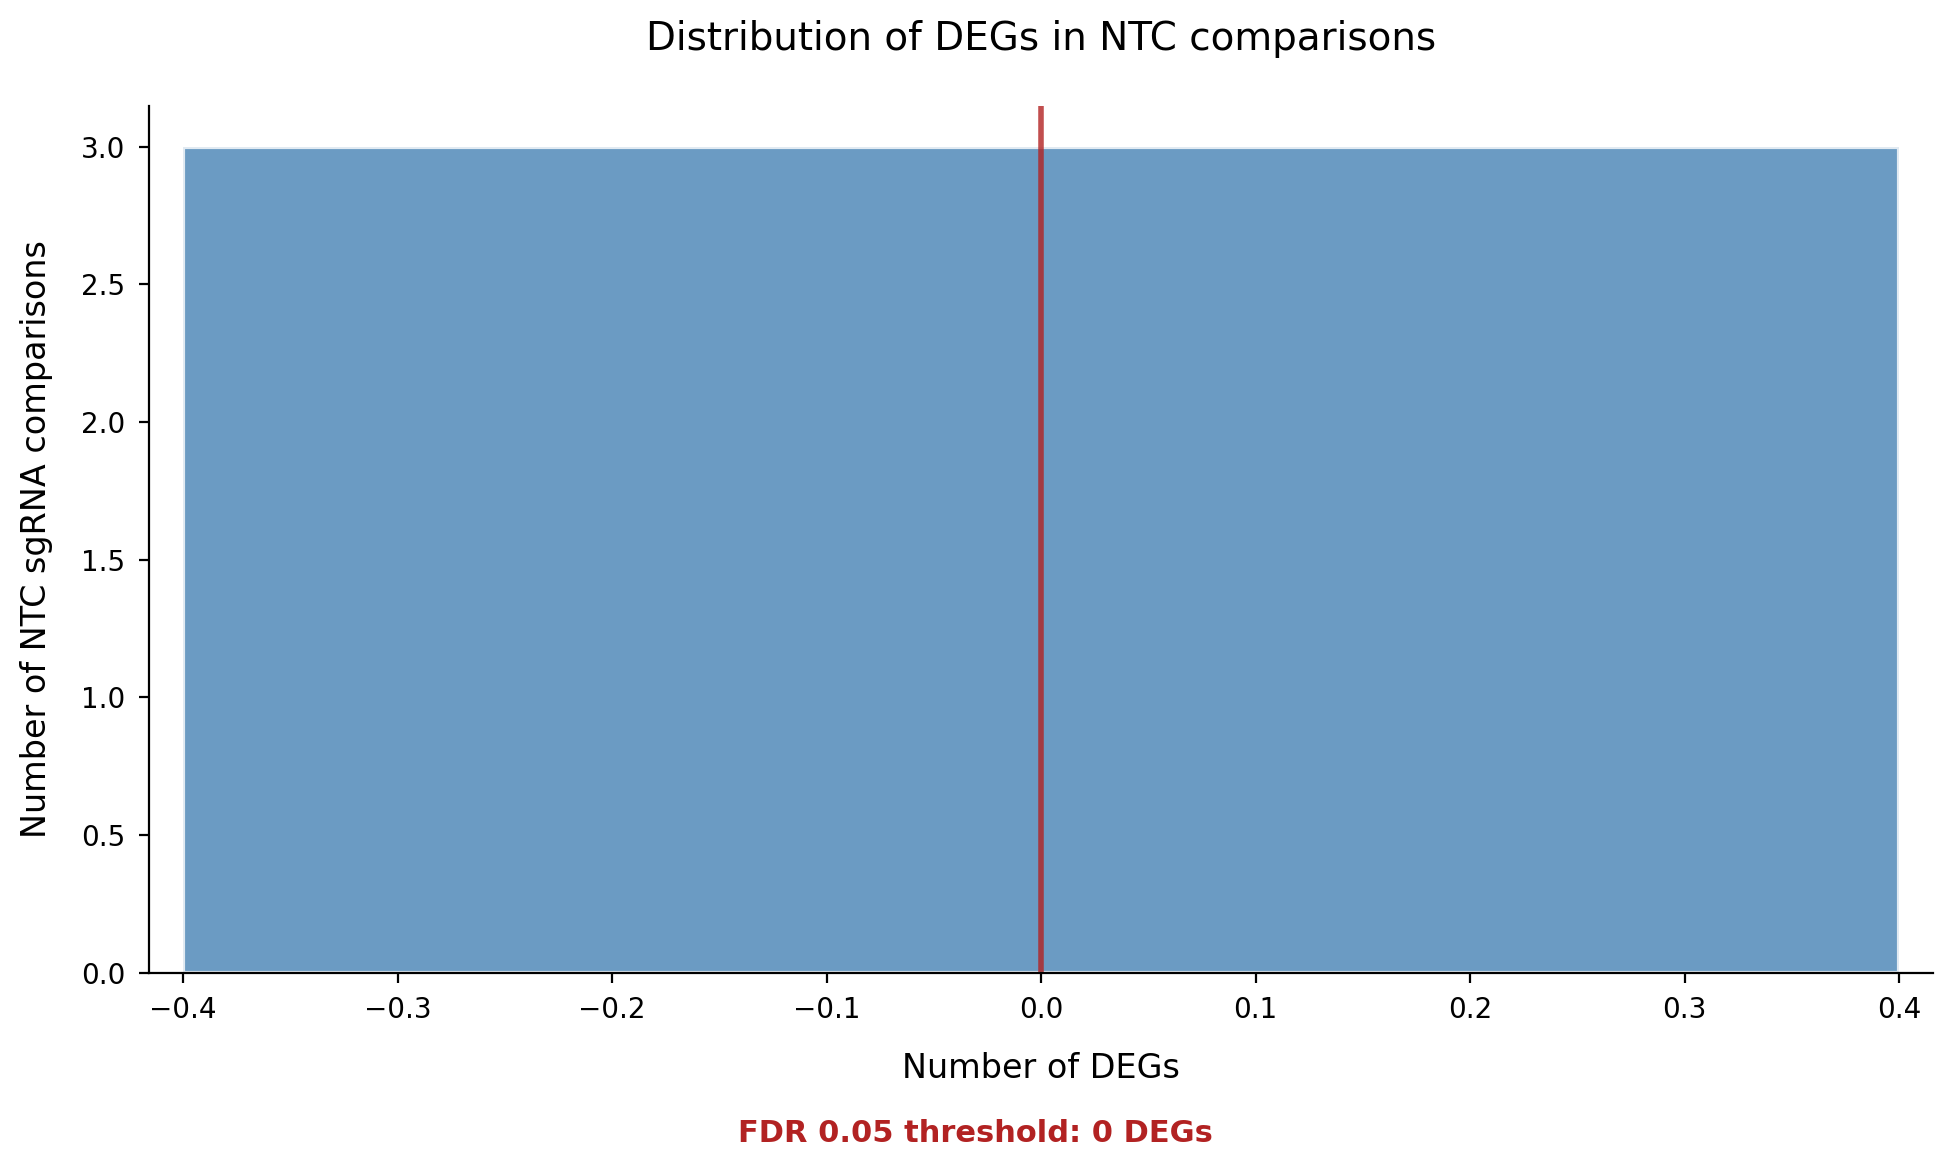

2025-10-30 14:00:58 - WARNING - Could not determine DEG count column. FDR significance column not added.


In [7]:
pipeline_test_adata = adata.copy()
pipeline_ntc_benchmark_results = \
    psp.de.benchmark_NTC_FDR(pipeline_test_adata, debug=True)

2025-10-30 14:04:50 - INFO - Using 13674 non-targeting control cells for benchmarking
2025-10-30 14:04:50 - INFO - Found 234 unique NTC sgRNAs


Benchmarking NTC sgRNAs:   0%|          | 0/234 [00:00<?, ?it/s]

/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
/home/ranwyl/psp_env/lib64/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning:

2025-10-30 14:41:04 - INFO - Stored NTC FDR threshold (1) in adata.uns['ntc_fdr_threshold']
2025-10-30 14:41:04 - INFO - NTC Benchmark Statistics:
2025-10-30 14:41:04 - INFO -   • FDR 0.05 threshold: 1 DEGs
2025-10-30 14:41:04 - INFO -   • NTC comparisons analyzed: 234
2025-10-30 14:41:04 - INFO -   • Mean DEGs per comparison: 0.2
2025-10-30 14:41:04 - INFO -   • Median DEGs per comparison: 0.0
2025-10-30 14:41:04 - INFO -   • 95% of comparisons have < 1 DEGs


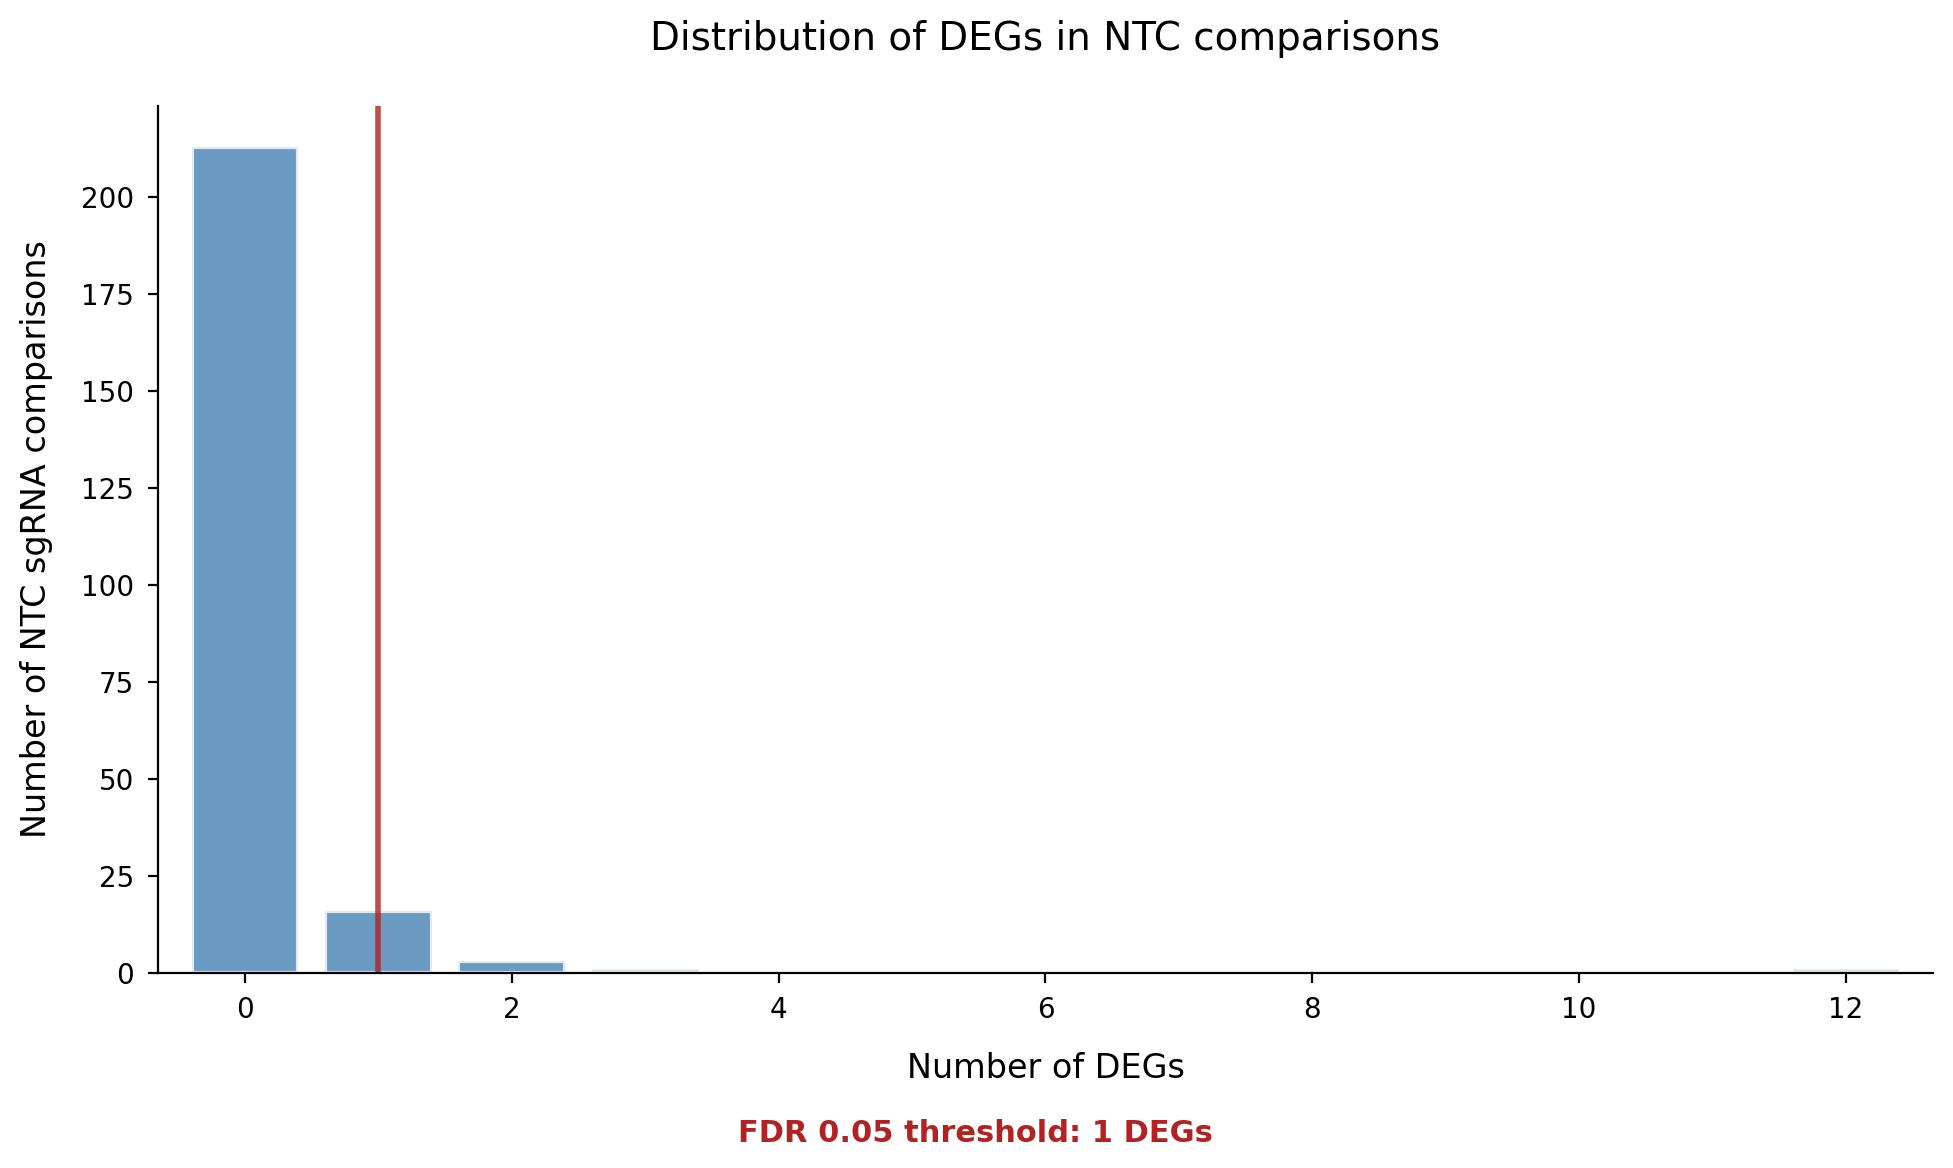

2025-10-30 14:41:04 - WARNING - Could not determine DEG count column. FDR significance column not added.


In [8]:
pipeline_adata = adata.copy()
pipeline_ntc_benchmark_results = \
    psp.de.benchmark_NTC_FDR(pipeline_adata)

In [14]:
pipeline_ntc_res = pipeline_ntc_benchmark_results[1]
pipeline_ntc_res.head()

,n_DEGs,sgRNA
key,,
Non-Targeting_516,12,Non-Targeting_516
Non-Targeting_254,3,Non-Targeting_254
Non-Targeting_334,2,Non-Targeting_334
Non-Targeting_863,2,Non-Targeting_863
Non-Targeting_415,2,Non-Targeting_415


In [17]:
ntc_gRNA_high_n_degs = pipeline_ntc_res.head().index.tolist()
print(ntc_gRNA_high_n_degs)

['Non-Targeting_516', 'Non-Targeting_254', 'Non-Targeting_334', 'Non-Targeting_863', 'Non-Targeting_415']


In [19]:
ntc_gRNA_n_cells = [adata[adata.obs.gRNA == gRNA].shape[0] for gRNA in ntc_gRNA_high_n_degs]
print(ntc_gRNA_n_cells)

[41, 56, 77, 65, 55]


In [15]:
pipeline_ntc_res["n_DEGs"].value_counts()

n_DEGs
0     213
1      16
2       3
12      1
3       1
Name: count, dtype: int64

# Old DE code

Write out results

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_10_2_2025.pkl"
DE_results.to_pickle(filepath_pkl)

Rename genes that are listed by Ensembl ID but have a gene name

In [ ]:
all_genes = DE_results.index.tolist()
ensg_genes = [g for g in all_genes if g.startswith("ENSG")]
print(len(ensg_genes))
print(ensg_genes[:5])

In [ ]:
mg = get_client('gene')
ensembl_results_all = mg.querymany(ensg_genes, fields='symbol', species='human')

Manually search for the genes with duplicate hits on GeneCards. To break ties, use the highest GeneCards Inferred Functionality Score (GIFtS). If there is a tie between highest scoring gene symbols, keep the gene as its Ensembl ID.

In [ ]:
# Change this
dup_hits = {'ENSG00000234352': 'LOC349160', 'ENSG00000249738':'IL12B-AS1', 'ENSG00000257545':'LOC100287944'}

Rename genes

In [ ]:
ensembl_to_gene = dict()
for r in ensembl_results_all:
  if r.get('symbol'):
      ensembl_to_gene[r.get('query')] = r.get('symbol')
ensembl_to_gene.update(dup_hits) # Change duplicate hits
print(len(ensembl_to_gene))

In [ ]:
def rename_ensembl_genes(de_df, ensembl_to_gene_dict):
    """
    Rename genes in DataFrame.
    """
    de_df_renamed = de_df.rename(index=ensembl_to_gene_dict)
    print(f"Converted {len(ensembl_to_gene_dict)} Ensembl IDs to gene symbols")
    return de_df_renamed

In [ ]:
DE_results_renamed = rename_ensembl_genes(DE_results, ensembl_to_gene)

In [ ]:
filepath_pkl = "/home/ranwyl/results_tf_project/DE_results_gene_names_09-2025.pkl"
DE_results_renamed.to_pickle(filepath_pkl)